# DEA CoastLines validation

To do:
* [ ] Change output CRS to Australian Albers

## Load modules/functions


In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd

import deacoastlines_validation as deacl_val

## Pre-processing

### NSW Beach Profile Database



In [ ]:
for fname in glob.glob('input_data/nswbpd/*.csv')[0:2]:
    deacl_val.preprocess_nswbpd(fname, overwrite=False)      


## WRL Narrabeen 

In [ ]:
deacl_val.preprocess_narrabeen(fname='input_data/wrl/Narrabeen_Profiles_2018.csv',
                               fname_out='output_data/wrl_narrabeen.csv',
                               overwrite=True)


## City of Gold Coast

## Analysis

In [27]:
val_paths = glob.glob('output_data/*.csv')[0:5]
# val_paths = ['output_data/wrl_narrabeen.csv']
deacl_path = '../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp'

stats_list = []

for val_path in val_paths:
    
    # Run analysis and close resulting figure
    output_stats = deacl_val.deacl_validation(val_path, deacl_path)
    plt.close()
    
    # Append stats to list
    stats_list.append(output_stats)
    
# Combine stats into a dataframe
stats_df = pd.DataFrame([stats for stats in stats_list if stats])
stats_df.head()

,site,rmse,mae,r2,cor
0,nswbpd_soldiersbeach,8.032019,6.304428,0.350221,0.739625
1,nswbpd_mullaway,19.078672,13.903696,0.583296,0.833915
2,nswbpd_patchsbeach,31.811387,29.173729,-0.779919,0.668052
3,nswbpd_coniston,18.722770,16.177429,-1.930746,0.577370


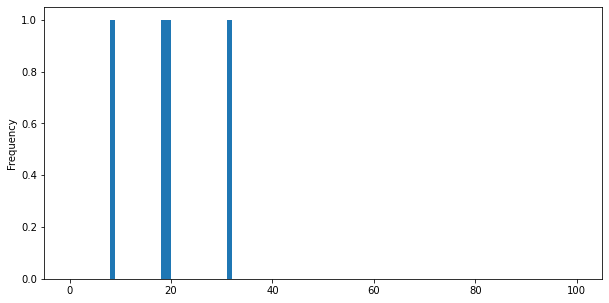

In [33]:
stats_df.rmse.plot.hist(bins=50, figsize=(10, 5), range=(0, 100))

In [ ]:
merge_test.groupby('year').median().reset_index().plot(x='year', y='DEA CoastLines beach width (m)')
merge_test.groupby('year').median().reset_index().plot(x='year', y='Validation beach width (m)', ax=plt.gca())

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020